<a href="https://colab.research.google.com/github/synsense/snn-workshop-amld-2022/blob/master/2.%20vision%20processing/dance_recognition_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dance recognition - complete

## Setup
First we download the dataset and install missing packages.

In [3]:
import zipfile
from pathlib import Path

# - Download of dataset
dataset_path = Path("/content") / "body-postures-dataset"

if not dataset_path.exists():
  !wget -q --show-progress https://www.dropbox.com/s/b9gfafnh6aesrsu/body-postures-dataset.bin
  # alternative mirror: https://lenzgregor.com/nextcloud/s/tbamCq9Eo95qfLc/download/body-postures-dataset.bin
  !mv body-postures-dataset.bin body-postures-dataset.tar.gz
  !tar -xzf body-postures-dataset.tar.gz

# - Install dataset as package
!pip install ./body-postures-dataset --quiet

# - Install torchmetrics
!pip install torchmetrics --quiet

  Preparing metadata (setup.py) ... done


In [4]:
import torch
import torchmetrics
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

## Data inspection

The original data consits of a continuous stream of asynchronous events - each with its own time stamp. On an asynchronous neuromorhpic processor, the dynamics of the network are continuous in time and are directly linked to the timings of the input events.

However, we are going to train our model on a CPU or GPU, which are synchronous (clocked) compute architectures. We therefore need to represent the envents in discretized time. We are going to use two different ways of arranging the events, depending on the type of neural network into which we are feeding the data.

### Frame representation

For artificial neural networks (ANNs), we will split the data stream of each recording into segments, each with the same, pre-defined number of events.

In the individual segments we count the number of events for each pixel and channel. This way we eliminate the time dimension, such that each segment now has become a static frame. The frames could be compared to grey-scale images, with the brightness corresponding to the event count. Nothe that different to the frames of a conventional video camera, each frame here generally represents a different amount of time.

The frame based representation is provided by `BodyPostureFrames`, which is a subclass of a PyTorch dataset.

In [5]:
from body_postures import BodyPostureFrames

?BodyPostureFrames

We will use this class to provide the input for training an ANN. Let's generate a training and and a test set. It might take a few seconds to convert the events into frames.

In [6]:
# The number of events per frame
event_count = 3000

# Ignore pixels where the firing frequency exceeds a given value
hot_pixel_filter_freq = 60

# Training dataset
frame_dataset_training = BodyPostureFrames(
    data_path=dataset_path / "data" / "train",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/train/{event_count}events_{hot_pixel_filter_freq}filter',
)

# Validation dataset
frame_dataset_validation = BodyPostureFrames(
    data_path=dataset_path / "data" / "test",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/test/{event_count}events_{hot_pixel_filter_freq}filter',
)

classes = frame_dataset_training.classes
shape = frame_dataset_training.shape
n_classes = len(classes)


Metadata written to metadata/frames/train/3000events_60filter/slice_metadata.h5.
Metadata written to metadata/frames/test/3000events_60filter/slice_metadata.h5.


It can happen that some pixels of our sensor just produce random events at a high rate. We want to ignore these. With the `hot_pixel_filter_freq` argument we set an upper limit for which event rate we consider reasonable. Any pixel emitting events at a higher rate is probably just generating noise and will be ignored.

For efficient data loading we do the conversion of events into frames only once and then buffer the data on disk, under the `metadata_path`.

Let's have a closer look at our data! For this we pick some frame from our training set:

Frame data type: <class 'numpy.ndarray'>
Frame shape: (1, 128, 128)
Frame sum: 3000.0
Max. number events at single pixel: 31.0


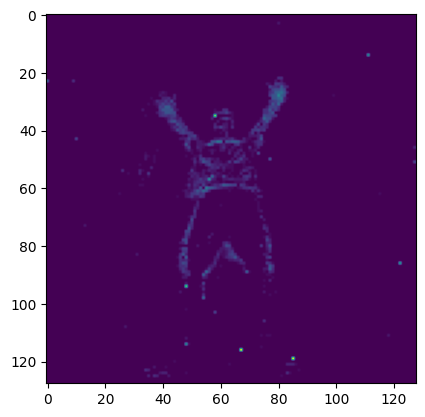

In [7]:
sample_index = 42
frame, label = frame_dataset_training[sample_index]

print("Frame data type:", type(frame))
print("Frame shape:", frame.shape)
print("Frame sum:", frame.sum())
print("Max. number events at single pixel:", frame.max())
plt.imshow(frame[0])

The frame is a numpy array of shape (1, 128, 128). The first dimension is the number of channels, which in this case is 1. The other two dimensions correspond to the image size. We see that our input has a resolution of 128x128.

We also note that the total number of events in the frame is 3000, which is what we have previously defined with the `event_count` argument.

When plotting the frame, brighter areas correspond to regions with a higher number of events. Because events are generated from intensity changes, those are the regions where something is happening. Any static background becomes invisible and we only see the shape of the person moving in front of the sensor.

### Ground truth

Every sample in the dataset comes with a label that enumerates the correct class. The `classes` dict maps the names of the classes to their integer labels. There are five poses ("clap", "mj", "salive", "star" and "wave") as well as a "background" class for recordings without any person and "other", when a person is not performing any known move.

In [8]:
print("Label:", label)
print(classes)

# Dict to map labels to classes
lbl2clss = {lbl: clss for clss, lbl in classes.items()}

Label: 4
{'background': 0, 'clap': 1, 'mj': 2, 'salive': 3, 'star': 4, 'wave': 5, 'other': 6}


### View frames

In [9]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc

rc('animation', html='jshtml')

In the following you can take a look at an animation of a short sequence of  frames. Change the `start_index` to see different parts of the dataset.

In [10]:
start_index = 3050

fig, ax = plt.subplots()

ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

screen = ax.imshow(frame_dataset_training[start_index][0][0], vmin=0, vmax=10)

def update_plot(idx):
    frame, label = frame_dataset_training[start_index + idx]
    screen.set_data(frame[0])
    ax.set_title(f"Label: {label} (`{lbl2clss[label]}`)")
    return screen,

anim = FuncAnimation(fig, update_plot, frames=20)
plt.close()
anim

### Data balancing

The dataset is imbalanced. Let's look at training and testing set distribution and rectify the training set by using weighted random sampling.

In [11]:
from torch.utils.data.sampler import WeightedRandomSampler

def get_weight_sampler(dataset):
  targets = []
  for data, target in iter(dataset):
    targets.append(target)
  targets = np.array(targets)

  count = np.bincount(targets)
  frac = count / np.sum(count)
  sample_weights_per_class = dict(zip(range(n_classes), 1 / frac / count.sum()))

  sample_weights = [sample_weights_per_class[target] for target in targets]
  sampler = WeightedRandomSampler(sample_weights, len(dataset), replacement=True)
  return sampler

In [12]:
batch_size = 256
train_loader = DataLoader(
    dataset=frame_dataset_training,
    batch_size=batch_size,
    sampler=get_weight_sampler(frame_dataset_training)
    )

test_loader = DataLoader(
    dataset=frame_dataset_validation,
    batch_size=batch_size,
    )

In [13]:

def plot_sample_dist(dataloader):
  resampled_targets = []
  for data, target in iter(dataloader):
    resampled_targets.append(target)
  resampled_targets = torch.cat(resampled_targets).numpy()

  plt.bar(classes.keys(), np.bincount(resampled_targets))
  plt.ylabel("Number of samples")

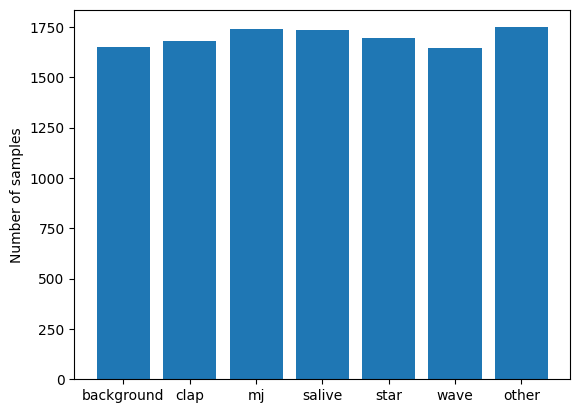

In [14]:
plot_sample_dist(train_loader)

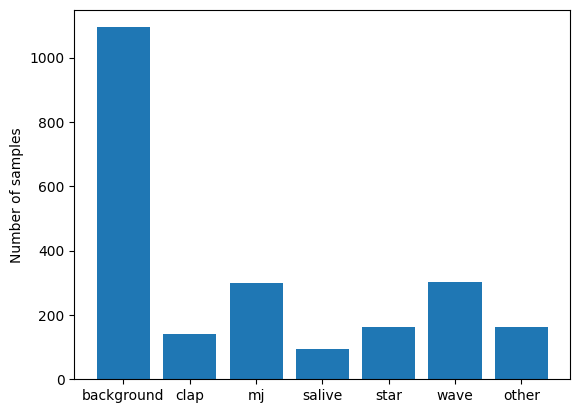

In [15]:
plot_sample_dist(test_loader)

### Settings and hyperparameters

You can try out different learning rates and weight decays here, but the providedd defaults should yield reasonable results.

In [16]:
learning_rate = 1e-3
weight_decay = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}.")

Using device cuda.


### Model definition

We suggest to use the following model architecture. Remember, the input shape of each frame is (1, 128, 128). Note that we disable biases because they are tricky to convert to SNNs and in this case not needed.

In [17]:
class ANN(nn.Sequential):
    def __init__(self, n_classes=10):
        super().__init__(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 16, 64, 64
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 32, 32
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 32, 16, 16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 32, 8, 8
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),  # 64, 4, 4
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 64, 2, 2
            nn.Flatten(),
            nn.Dropout2d(0.5),

            nn.Linear(32*4*4, n_classes, bias=False),
        )

In [19]:
ann = ANN(n_classes).to(device)

# - Loss
criterion = torch.nn.CrossEntropyLoss()

# - Optimizer
optimizer = torch.optim.Adam(ann.parameters(), lr=learning_rate, weight_decay=weight_decay)

# - Confusion matrix
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=n_classes)

num_epochs = 10
validate_every = 5

# We use augmentation because we're oversampling underrepresented classes.
augmentation = torchvision.transforms.RandomAffine(degrees=10, translate=[0.1, 0.1])

# Track losses
training_losses = []
val_losses = []
val_accuracy = 0
val_loss = 0

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    batch_loss = []
    for data, labels in iter(train_loader):
        # Forward pass
        data = data.to(device)
        data = augmentation(data)
        logits = ann(data)
        # Loss for current batch
        loss = criterion(logits, labels.to(device))
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        optimizer.zero_grad()
        batch_loss.append(loss.item())

    train_loss = sum(batch_loss) / len(batch_loss)
    training_losses.append(train_loss)
    pbar_epoch.set_postfix(train_loss=train_loss, val_loss=val_loss, val_acc=val_accuracy)

    # Validation
    if validate_every is not None and (epoch + 1) % validate_every == 0:
        with torch.no_grad():
            val_data = []
            batch_loss = []
            for data, labels in iter(test_loader):
                logits = ann(data.to(device))
                # Loss
                loss = criterion(logits, labels.to(device))
                batch_loss.append(loss.item())
                # Collect outputs and labels
                predictions = torch.max(logits, dim=1)[1]
                val_data.append((predictions.detach().cpu(), labels.detach().cpu()))

            val_loss = sum(batch_loss) / len(batch_loss)
            val_losses.append(val_loss)

            # Calculate accuracy
            confusion_list = [confusion_matrix(pred, label) for pred, label in val_data]
            confusion = torch.stack(confusion_list).sum(0)
            val_accuracy = (confusion.trace() / confusion.sum()).item()

        pbar_epoch.set_postfix(train_loss=train_loss, val_loss=val_loss, val_acc=val_accuracy)




Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


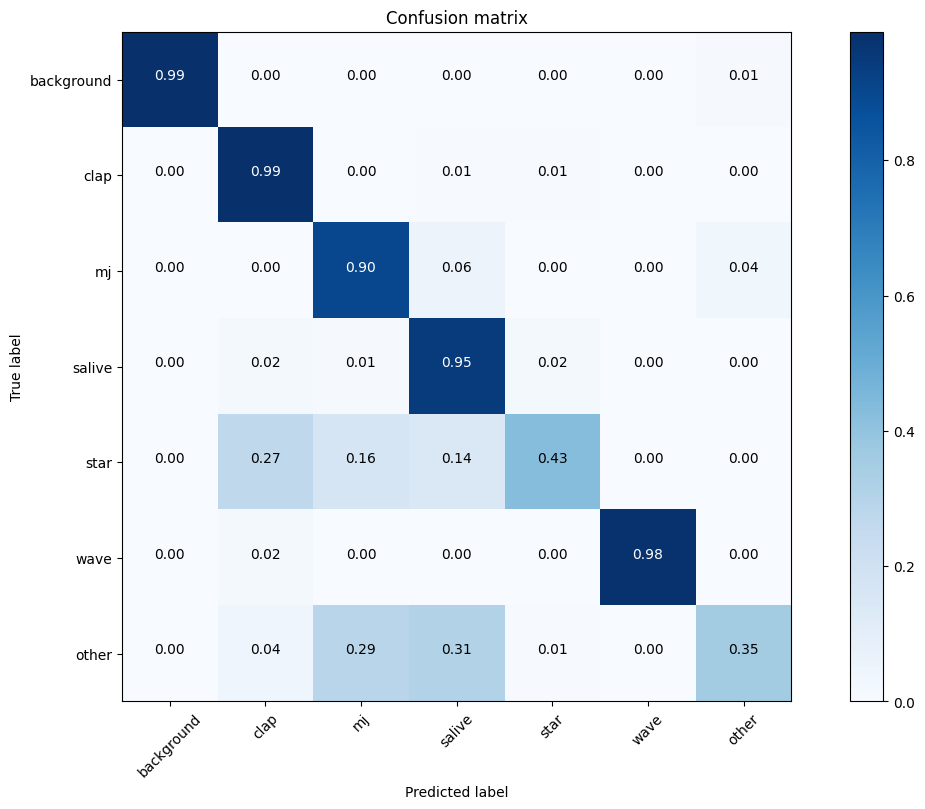

In [20]:
import itertools

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion.numpy(), classes.keys())

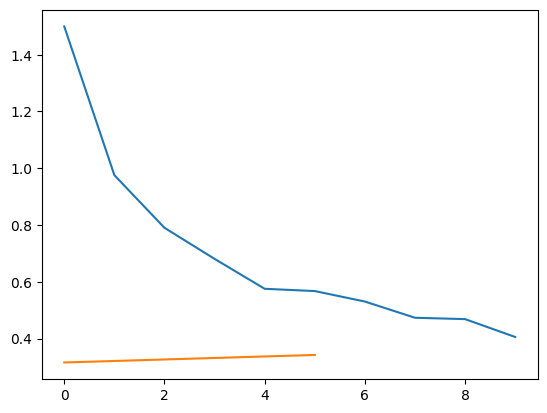

In [21]:
plt.plot(training_losses)
plt.plot(range(0, len(training_losses), validate_every), val_losses)

# Convert ANN to SNN

For working with SNNs we will use our in-house library Sinabs. You can find out more about here: https://sinabs.readthedocs.io/en/develop/index.html .

In [22]:
# - Make sure sinabs is installed

sinabs_path = Path("/content") / "sinabs"

if not sinabs_path.exists():
  !git clone https://github.com/synsense/sinabs.git
  !cd sinabs; pip install . --quiet

Cloning into 'sinabs'...
remote: Enumerating objects: 5076, done.
remote: Counting objects: 100% (1163/1163), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 5076 (delta 787), reused 1083 (delta 726), pack-reused 3913
Receiving objects: 100% (5076/5076), 4.18 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (3632/3632), done.
  Preparing metadata (setup.py) ... done


Before converting our trained ANN to a spiking neural network, we need to make sure that the weights are scaled correctly, such that the spiking activities in each layer are normalized. For this we use the `normalize_weights` function of sinabs:

In [23]:
import sinabs
import copy

# - Generate a copy with original weights
ann_original = copy.deepcopy(ann)

# - Find names of activation layers, that will be converted to spiking layers
spike_layers = [name for name, child in ann.cpu().named_children() if isinstance(child, nn.ReLU)]
# - Find names of layers with weights to be scaled
param_layers = [name for name, child in ann.cpu().named_children() if isinstance(child, (nn.Conv2d, nn.Linear))]
# - First data sample from the training set to gauge network activity
data = next(iter(train_loader))[0]

# - Normalize the weights of the ANN
sinabs.utils.normalize_weights(ann, data, output_layers=spike_layers, param_layers=param_layers)

We can scale up the weights of the first layer. This increases the overall activity in our network, such that it becomes a closer approximation of the ReLU activations in the ANN. Don't exaggerate, however. Too strong activity in the network will drive up power consumption on the hardware.

In [24]:
with torch.no_grad():
  ann[0].weight *= 5

Now our ANN is ready to be converted to an SNN. For this, we need to provide the shape of the input. We also tell sinabs to add another spiking layer after the final layer of our network. This is to make sure that the SNN output consists of events, for compatibility with our Speck chip.

In [26]:
batch_size = 1

snn = sinabs.from_torch.from_model(ann, input_shape=(1, 128, 128), batch_size=batch_size, add_spiking_output=True)
snn

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Network(
  (spiking_model): ANN(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=1, num_timesteps=-1)
    (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=1, num_timesteps=-1)
    (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=1, num_timesteps=-1)
    (10): AvgPool2d(kernel_si

Looking at the new SNN, we see that it contains a copy of the original ANN as well as the actual spiking neural network. In the forward call, only the spiking part will be active.

In [27]:
# - Save the model

torch.save(snn, 'spiking_model.pth')

In [28]:
# Load previously saved model

snn = torch.load('spiking_model.pth')
print("Loaded saved model.")

Loaded saved model.


## Evaluate converted SNN on event data

Before testing our SNN, let's have a brief look at the data we are feeding it.

### Event Representation

For spiking neural networks (SNNs) we use a similar representation to the frames we used for the ANN. However, here we want to maintain a notion of time, to mimick the neuron dynamics on the neuromorphic processor. We therefore arrange our events in time along a grid of very short intervals, corresponding to a simulation time step. This time step should be chosen small enough such that the neuron dynamics are well approximated. On the other hand, choosing it too short will slow down our simulations.

Data in this format will be porovided to us by the class `BodyPostureEvents`.

In [29]:
from body_postures import BodyPostureEvents

In [30]:
?BodyPostureEvents

In [31]:
slice_dt = 2e6 # microseconds
bin_dt = 2e3

raster_test_dataset = BodyPostureEvents(
    data_path=dataset_path / "data" / "test",
    cache_path=f"cache/test/{slice_dt}/{bin_dt}",
    slice_dt=slice_dt,
    bin_dt=bin_dt,
    metadata_path=f"metadata/raster/test/{slice_dt}/{bin_dt}",
    hot_pixel_filter_freq=hot_pixel_filter_freq,
)

test_loader = DataLoader(raster_test_dataset, shuffle=True, batch_size=batch_size)

Metadata written to metadata/raster/test/2000000.0/2000.0/slice_metadata.h5.


Let's take a look at the data now. You can set the `sample_index` to inspect different samples from the dataset. In contrast to the frames of the `BodyPostureFrames` data, the events of each sample are spread along a time axis. Therefore we see way fewer events at any given time bin. Note that due to computational limiations we are only animating the first few timesteps of each sample.

In [32]:
sample_index = 0

fig, ax = plt.subplots()

ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

screen = ax.imshow(raster_test_dataset[sample_index][0][0, 0], vmin=0, vmax=1)

def update_plot(idx):
    frame, label = raster_test_dataset[sample_index]
    screen.set_data(frame[idx, 0])
    ax.set_title(f"Label: {label} (`{lbl2clss[label]}`)")
    return screen,

anim = FuncAnimation(fig, update_plot, frames=20)
plt.close()
anim

## Inference on the SNN

Time to feed our SNN with data and see how it performs!

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

snn.eval()
snn = snn.to(device)

val_data = []
pbar =  tqdm(test_loader)
for data, labels in pbar:
  with torch.no_grad():
    snn.reset_states()
    data = data.to(device)
    data = data.flatten(0, 1).float()
    spikes = snn(data).unflatten(0, (batch_size, -1))

    # Collect outputs and labels
    predictions = spikes.sum(1).argmax(dim=1)
    val_data.append((predictions.detach().cpu(), labels.detach().cpu()))



  0%|          | 0/263 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [35]:
# Calculate accuracy
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=n_classes)
confusion_list = [confusion_matrix(pred, label) for pred, label in val_data]
confusion = torch.stack(confusion_list).sum(0)
val_accuracy = (confusion.trace() / confusion.sum()).item()

print(f"Validation accuracy on SNN: {val_accuracy}")

Validation accuracy on SNN: 0.6882129311561584


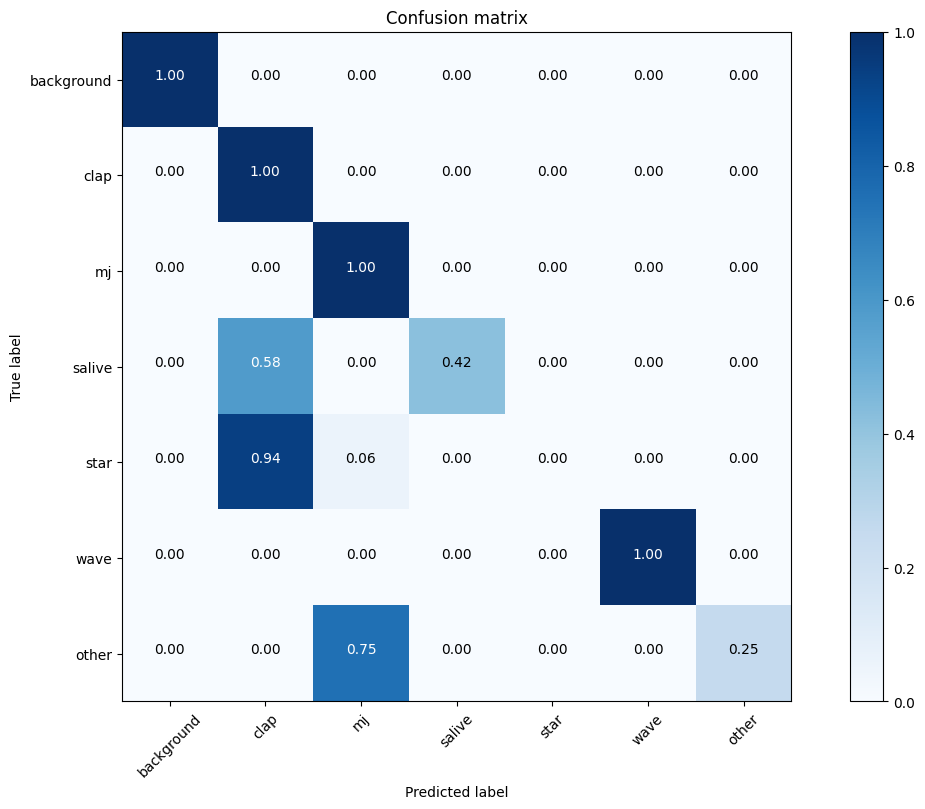

In [36]:
plot_confusion_matrix(confusion.numpy(), classes.keys())

## Run your model on neuromorphic hardware

Upload your model to the following dropbox link: https://www.dropbox.com/request/uwBr6x2kkuV9hC15xNSX
and talk to one of the organizers to see your model in action on our Speck chip!